In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn 
import pandas as pd
import os, gc, sys, time
import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

## **1.1数据集titanic**

In [2]:
train_file = './data/titanic/titanic_train.csv'
eval_file = './data/titanic/titanic_eval.csv'

train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)

train_df.head(5)

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [3]:
y_train = train_df.pop('survived')
y_eval = eval_df.pop('survived')

train_df.head(10)

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y
5,male,2.0,3,1,21.0750,Third,unknown,Southampton,n
6,female,27.0,0,2,11.1333,Third,unknown,Southampton,n
7,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n
8,female,4.0,1,1,16.7000,Third,G,Southampton,n
9,male,20.0,0,0,8.0500,Third,unknown,Southampton,y


In [4]:
train_df.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [5]:
print(train_df.shape, eval_df.shape)

(627, 9) (264, 9)


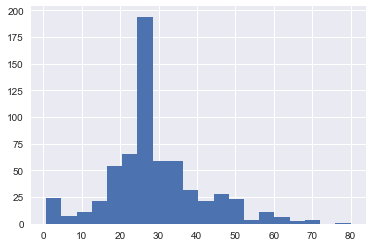

In [6]:
train_df.age.hist(bins = 20) # 年龄分布

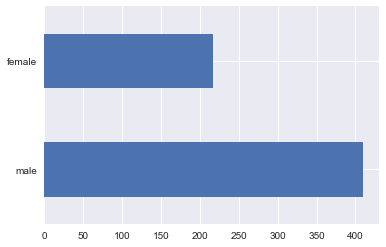

In [7]:
train_df.sex.value_counts().plot(kind='barh') # 性别分布

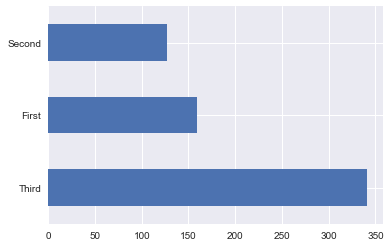

In [8]:
train_df['class'].value_counts().plot(kind='barh') # class与自带函数冲突, 舱位分布

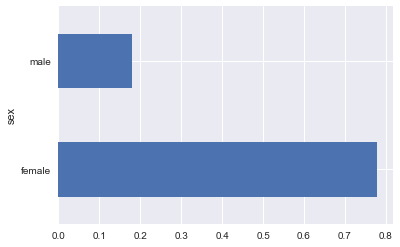

In [9]:
pd.concat([train_df, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh') # 男女获救比例

## **1.2 feature_column的使用**
**离散特征**: one-hot编码     
**连续特征**: 分桶

In [10]:
categorical_columns = ['sex', 'n_siblings_spouses', 'parch', 'class',
                       'deck', 'embark_town', 'alone']
numeric_columns = ['age', 'fare']

feature_columns = []

# 将类别特征转换为one-hot的特征
for categorical_column in categorical_columns:
    vocab = train_df[categorical_column].unique()
    # 使用tf.feature_columns下的api
    feature_columns.append(tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(categorical_column, vocab)))
for categorical_column in numeric_columns:
    feature_columns.append(tf.feature_column.numeric_column(categorical_column, dtype=tf.float32))

In [11]:
def make_dataset(data_df, label_df, epochs = 10, shuffle = True, batch_size = 32):
    dataset = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
        dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset

In [12]:
train_dataset = make_dataset(train_df, y_train, batch_size=5)

In [13]:
for x, y in train_dataset.take(1):
    print(x, y)

{'sex': <tf.Tensor: id=38, shape=(5,), dtype=string, numpy=array([b'male', b'female', b'female', b'female', b'male'], dtype=object)>, 'age': <tf.Tensor: id=30, shape=(5,), dtype=float64, numpy=array([22., 38., 26., 35., 28.])>, 'n_siblings_spouses': <tf.Tensor: id=36, shape=(5,), dtype=int32, numpy=array([1, 1, 0, 1, 0])>, 'parch': <tf.Tensor: id=37, shape=(5,), dtype=int32, numpy=array([0, 0, 0, 0, 0])>, 'fare': <tf.Tensor: id=35, shape=(5,), dtype=float64, numpy=array([ 7.25  , 71.2833,  7.925 , 53.1   ,  8.4583])>, 'class': <tf.Tensor: id=32, shape=(5,), dtype=string, numpy=array([b'Third', b'First', b'Third', b'First', b'Third'], dtype=object)>, 'deck': <tf.Tensor: id=33, shape=(5,), dtype=string, numpy=array([b'unknown', b'C', b'unknown', b'C', b'unknown'], dtype=object)>, 'embark_town': <tf.Tensor: id=34, shape=(5,), dtype=string, numpy=
array([b'Southampton', b'Cherbourg', b'Southampton', b'Southampton',
       b'Queenstown'], dtype=object)>, 'alone': <tf.Tensor: id=31, shape=(5

## **1.3 使用DenseFeature来使用feature_column**

feature_columns定义的是特征转换的规则，keras.layers.DenseFeature将规则运用在dataset上

In [14]:
for x, y in train_dataset.take(1):
    age_column = feature_columns[7]
    gender_column = feature_columns[0]
    print(keras.layers.DenseFeatures(age_column)(x).numpy())
    print(keras.layers.DenseFeatures(gender_column)(x).numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[22.]
 [38.]
 [26.]
 [35.]
 [28.]]

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base 

In [15]:
for x, y in train_dataset.take(1):
    print(keras.layers.DenseFeatures(feature_columns)(x).numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[22.      1.      0.      1.      0.      0.      1.      0.      0.
   0.      0.      0.      0.      0.      1.      0.      0.      0.
   7.25    1.      0.      0.      0.      0.      0.      0.      1.
   0.      0.      0.      0.      0.      1.      0.    ]
 [38.      1.      0.      0.      1.      0.      0.      1.      0.
   0.      0.      0.      0.      0.      0.      1.      0.      0.
  71.2833  1.      0.      0.      0.      0.      0.      0.      1.
   0.      0.      0.      0.

## **1.4 利用DenseFeature来构建模型**

In [16]:
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = keras.optimizers.Adam(lr=0.01),
              metrics = ['accuracy'])

有两种训练的模式
- 直接调用fit的方法
- 将model转换为estimator，然后再进行训练

In [18]:
train_dataset = make_dataset(train_df, y_train, epochs=100, shuffle=True)
eval_dataset = make_dataset(eval_df, y_eval, epochs=1, shuffle=False)
history = model.fit(train_dataset,
                    validation_data = eval_dataset,
                    steps_per_epoch = 19, 
                    validation_steps = 8,
                    epochs = 100) 

Train for 19 steps, validate for 8 steps
Epoch 1/100
19/19 [==============================] - 0s 12ms/step - loss: 0.3630 - accuracy: 0.8388 - val_loss: 0.5187 - val_accuracy: 0.7773
Epoch 2/100
19/19 [==============================] - 0s 12ms/step - loss: 0.3583 - accuracy: 0.8536 - val_loss: 0.5233 - val_accuracy: 0.7930
Epoch 3/100
19/19 [==============================] - 0s 11ms/step - loss: 0.3486 - accuracy: 0.8487 - val_loss: 0.5076 - val_accuracy: 0.7930
Epoch 4/100
19/19 [==============================] - 0s 11ms/step - loss: 0.3328 - accuracy: 0.8553 - val_loss: 0.5139 - val_accuracy: 0.7891
Epoch 5/100
19/19 [==============================] - 0s 11ms/step - loss: 0.3371 - accuracy: 0.8520 - val_loss: 0.5153 - val_accuracy: 0.8086
Epoch 6/100
19/19 [==============================] - 0s 11ms/step - loss: 0.3437 - accuracy: 0.8454 - val_loss: 0.5105 - val_accuracy: 0.8086
Epoch 7/100
19/19 [==============================] - 0s 11ms/step - loss: 0.3380 - accuracy: 0.8536 - val_l

19/19 [==============================] - 0s 10ms/step - loss: 0.2996 - accuracy: 0.8766 - val_loss: 0.5418 - val_accuracy: 0.7969
Epoch 59/100
19/19 [==============================] - 0s 10ms/step - loss: 0.3167 - accuracy: 0.8766 - val_loss: 0.5507 - val_accuracy: 0.8008
Epoch 60/100
19/19 [==============================] - 0s 11ms/step - loss: 0.3234 - accuracy: 0.8668 - val_loss: 0.5753 - val_accuracy: 0.7891
Epoch 61/100
19/19 [==============================] - 0s 10ms/step - loss: 0.3145 - accuracy: 0.8668 - val_loss: 0.5551 - val_accuracy: 0.7891
Epoch 62/100
19/19 [==============================] - 0s 10ms/step - loss: 0.3059 - accuracy: 0.8766 - val_loss: 0.5495 - val_accuracy: 0.7930
Epoch 63/100
19/19 [==============================] - 0s 10ms/step - loss: 0.3031 - accuracy: 0.8766 - val_loss: 0.5735 - val_accuracy: 0.7891
Epoch 64/100
19/19 [==============================] - 0s 10ms/step - loss: 0.3166 - accuracy: 0.8668 - val_loss: 0.5959 - val_accuracy: 0.7891
Epoch 65/100

In [19]:
estimator = keras.estimator.model_to_estimator(model)
# input_fn: 返回结果必须是a.(features, labels) b. dataset(feature, label)
estimator.train(input_fn = lambda : make_dataset(train_df, y_train, epochs=100))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\11417\\AppData\\Local\\Temp\\tmptvns__95', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002321BDE4160>, '_task_type': 'worker', '_task_id': 0, '_globa

ValueError: Unexpectedly found an instance of type `<class 'dict'>`. Expected a symbolic tensor instance.

**这里是tf本身的问题，待到日后解决**